<h1>Fitting SPI spectra, step by step</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from matplotlib import colors

import emcee, time
from tqdm.autonotebook import tqdm as tqdm
import corner

# comment this out when you run on your machine
plt.style.use('thomas')

/Users/thomassiegert/.virtualenvs/testing/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
plt.style.use('thomas')

<h3>The main parts of what needs to be done is found in the SPIspectrumFits.py file in the spec_tools directory. We will import the functions here to show how it works by just calling the functions, and explain it in the notebook step by step.</h3>

In [3]:
# importing functions to read response matrix and fit data
from spec_tools.SPIspectrumFits import *

# spectral shapes we might want to use
from spec_tools.spectral_shapes import *

# priors on parameters if need be
from spec_tools.priors import *

<h3>First, we read in the data (spectrum with error bars), and the corresponding response file:</h3>

In [4]:
spec = fits.open('spec_tot_IC.fits.gz')

In [5]:
matrix,e_lo,e_hi,e_min,e_max = define_rsp_matrix('spectral_response.rmf.fits.gz')

Filename: spectral_response.rmf.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  GROUPING      1 BinTableHDU     50   2R x 9C   [8A, 32A, 1J, 1J, 256A, 3A, 1I, 1D, 1D]   
  2  MATRIX        1 BinTableHDU     47   377R x 6C   [1E, 1E, 1I, 1I, 1I, 1PE(24)]   
  3  EBOUNDS       1 BinTableHDU     40   24R x 3C   [1J, 1E, 1E]   


<h3>In our data set, we have 24 energy bins, from 30 keV to 8000 keV, almost logarithmically binned, with 2 small bins to include the 511 keV and the 1809 keV line.<br>
    The matrix that you see there is of dimension 24 (number of bins in data set) times 377 (number of bins where our model lives). We use more bins to calculate the model then what we actually have in the data set, so that when we integrate over wiggles in the functions, we capture all the flux. What I mean by this will become more evident below.<br>
    First, I show you how this matrix looks like. We define some auxiliary variables for the energies:</h3>

In [6]:
# auxiliary variables to define the bin centers (for plotting)
ee = (e_max+e_min)/2.   # centre of the bin
dee = (e_max-e_min)     # bin size
e_mean = (e_hi+e_lo)/2. # rmf matrix energies
de = (e_hi-e_lo)        # rmf matrix bin sizes 

<h3>Plot of the matrix</h3>

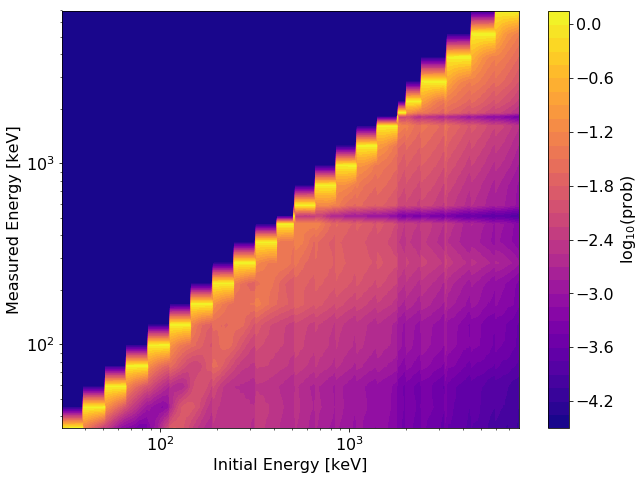

In [7]:
E_MEAN, EE = np.meshgrid(e_mean,ee)

plt.figure(figsize=(10.24,7.68))

plt.contourf(E_MEAN,EE,np.log10(matrix.T+matrix[matrix>0].min()),levels=40,cmap=plt.cm.plasma)
plt.ylabel('Measured Energy [keV]',fontsize=16)
plt.xlabel('Initial Energy [keV]',fontsize=16)

plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.colorbar(label='log$_{10}$(prob)')

<h3>We see that the redistribution matrix is very diagonal (this is due to the way the fit to the raw has been done before, but is not further of concern here). The matrix can be read in this way: suppose in your model, you predict a gamma-ray line at 1.809 MeV (initial energy = model space). The probability that a 1.809 MeV photon is measured (detected with SPI = data space) at 1.809 MeV is indeed very large (the diagonal), but there are non-zero probabilities that the initial 1.809 MeV is measured at lower energies. Thus, when we predict a mono-energetic line at 1.809 MeV, we have to fold it with this matrix, and expect to have measured photons below that initial energy.<br>
    (So, picking a point on the x-axis, say at 1.809 MeV, and going upward shows you the probability of measuring that initial photon at a lower energy until the diagonal is reached. You cannot go above.)<br><br>
    Example: A line at 1.809 MeV, with a width of 3 keV, and a total flux of 2e-3 ph/cm2/s:</h3>

<h3>In the "import spectral_shapes", we loaded all the functions in that file. It's easy to add more functions (or tabled functions like the PBH evaporation; example later). So we calculate our Gaussian in "model space" (initial energy), and compare it to the folded model in "data space" (measured energy). I will use these phrases synonymously in the following:</h3>

In [8]:
# defining the parameters
F_26 = 2e-3
E0_26 = 1809.
sigma_26 = 3.

pars_26 = [F_26, E0_26, sigma_26]

In [9]:
# calculate the model
model_26 = Gaussian(e_mean,pars_26)

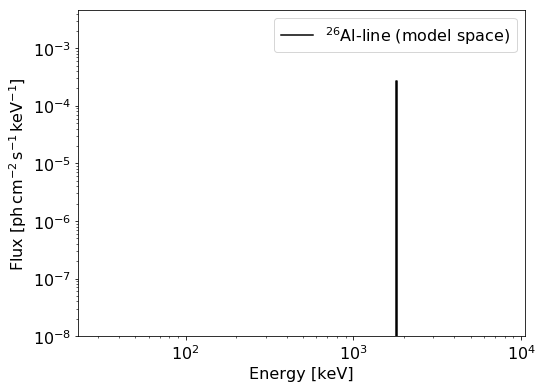

In [10]:
# plot the model
plt.step(e_mean,model_26,label=r'$\mathrm{^{26}Al}$-line (model space)')
plt.xlabel('Energy [keV]')
plt.ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8)
plt.legend()

<h3>The line is, as expected, a mono-energetic emission: one high bin in initial energy. Since the bin width is somewhat large, the width of line has barely any effect, and the "sum" of this spectrum is only accurate to some extent. For a real line analysis, one would need to do this is finer energy bins (beyond the scope here).<br><br>
    Now to convolve that spectrum to the data space we actually have (24 somewhat broad energy bins), we do the following:</h3>

In [11]:
conv_model_26 = SPI_model_fit(pars_26,              # (true) parameters
                              ee,                   # 24 energy bins
                              None,                 # important later 
                              dee,                  # 24 energy bin widths
                              None,                 # important later 
                              matrix,               # rmf 
                              e_lo,                 # rmf bins lo
                              e_hi,                 # rmf bins hi
                              function='Gaussian',  # fit function
                              eval=True)            # evaluate the model (rather than fit)

<h3>What is happening here, I showed briefly during our meeting: The true model in photon space, call it $f_i(E_ii;\mathbf{p})$ with a set of parameters $\mathbf{p}$ is smooth and lives in an infinitesimal space. Since we cannot calculate infinite model points, we calculate these models on a fine (depends on the case) grid. This is where the 377 points come from in the matrix.<br>
    This means we 'over-sample' our data points (the 24 broad bins) so that we can actually know what the model within the limits of one energy bin is. Thus we integrate $f_i(E_i;\mathbf{p})$ over the boundaries of each energy bin ${E_m^{lo}}$ and ${E_m^{hi}}$, such that<br>
    $F_i(E_m;\mathbf{p}) = \int_{E_m^{lo}}^{E_m^{hi}} \,dE_i f_i(E_i;\mathbf{p})$.<br>
    Now that we know how much flux really is expected in a bin (i.e. going from differential flux to flux), i.e. knowing how many photons we expect, we can redistribute these photons with the matrix,<br>
    $F_m(E_m;\mathbf{p}) = F_i(E_m;\mathbf{p}) \cdot H(E_m,E_i)$.<br>
    $F_m(E_m;\mathbf{p})$ is now the 'folded model' in 'data space', and plotted below. You see that the model still depends on the parameters, so that in a fit (see below), we always have to perform these intermediate steps. A backward or 'unfolding' of such a spectrum is impossible because the matrix is not invertible.<br>
    These steps are what XSPEC is doing, which however does not have all the positron things included, etc.<br><br>
    (How this is done in code is shown below as well for another example.)</h3>

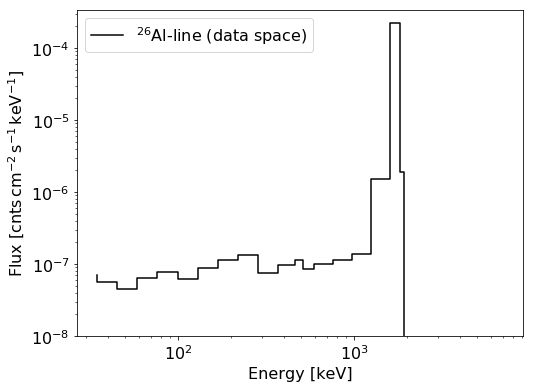

In [12]:
# plot the folded model
plt.step(ee,conv_model_26,label=r'$\mathrm{^{26}Al}$-line (data space)')
plt.xlabel('Energy [keV]')
plt.ylabel(r'Flux [$\mathrm{cnts\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-8)
plt.legend()

<h3>What we see here is the working principle of a Germanium detector (modulo all the geometry of the instrument, etc.): a monoenergetic line, for example from a radioactive decay, is <em>not</em> measured as a mono-energetic line, but as something that might look like this. Most of the counts (cf. y-label, now counts as opposed to photons above), that appear below the line are due to Compton scattering. If the spectrum would be more resolved, one would also see so-called escape peaks, i.e. a peak at the line energy minus 511 keV (or 1022 keV) when the electron or positron, or both, that have been created in the interaction of the photon with the detector, escape from being absorbed. And there would also be a 511 keV line (small peak seen here), because the positron might annihilate somewhere else.<br><br>
    Anyway, this redistribution is important when a spectral fit is done, even though the peak here is 1000 times stronger than the other bins: in terms of the total counts, the fraction of the Compton continuum to the total counts is ~40% (!). This effect depends on energy (cf. the matrix) and becomes more severe the higher the initial energy.<br><br>
    There is a secondary effect here (again because of how the SPI raw data was analysed before), that the counts in data space are actually 'higher' than then flux in model space. This is a correction which would otherwise mimic higher fluxes.<br>
    (I know this is a lot of information here, just trying to be somewhat complete.)</h3>

In [13]:
# fraction of line photons
np.sum(conv_model_26[17]*dee[17]) / np.sum(conv_model_26*dee)

0.6124006677868268

In [14]:
# fraction of continuum photons than have initial bin monochromatic
(np.sum(conv_model_26[0:17]*dee[0:17])+np.sum(conv_model_26[18:]*dee[18:])) / np.sum(conv_model_26*dee)

0.3875993322131731

<h3>Before we go on with the data in the file, let's simulate a power-law and fit that, so that the work-flow becomes evident:<br><br>
For this simulation, I will use an uncertainty on the flux as a function of the flux. This will not be the case for the real data. The power-law will be of the form<br>
    $\frac{dN}{dE\,dt\,dA}(E;C_0,\alpha) = C_0 \left( \frac{E}{E_0} \right)^\alpha$,<br>
    where $C_0$ is the normalisation at the pivot energy $E_0 = 1000$ keV in units of $\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$ and $\alpha$ is the power-law index.<br>
    I choose $C_0 = 10^{-5}$ and $\alpha=-3$.</h3>

In [15]:
# number of data points
n_ee = len(ee)

# true parameters
C0 = 1e-5
alpha = -3.
pars_pl = [C0,alpha]

# calculate model
fake_data_true = SPI_model_fit(pars_pl,
                               ee,
                               None,
                               dee,
                               None,
                               matrix,
                               e_lo,
                               e_hi,
                               function='powerlaw',
                               eval=True)

# uncertainty, given as signal to noise ratio per bin
# play around with this value to see how the data might actually vary
snr = 1./0.75
fake_data_err = fake_data_true/snr

# noise model
seed = 13337
# the seed is just there to make the example work out the same way
np.random.seed(seed)
fake_data = fake_data_true + np.random.randn(n_ee)*fake_data_err

<h3>By using the np.random.randn() function, we intrinsically defined our likelihood: we say our data follow a normal distribution. Before I explain what these words mean, let's plot the spectrum:</h3>

Text(0, 0.5, 'Flux [$\\mathrm{ph\\,cm^{-2}\\,s^{-1}\\,keV^{-1}}$]')

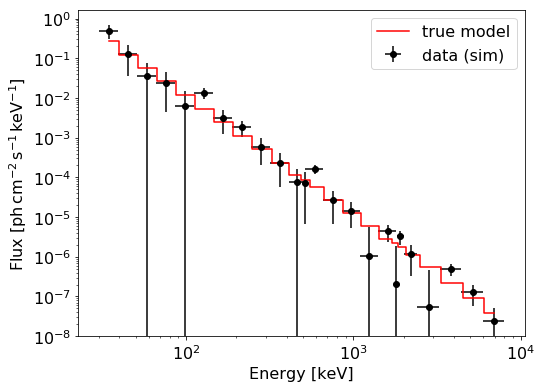

In [16]:
# plot simulated data
plt.errorbar(ee,
             fake_data,
             xerr=dee/2,
             yerr=fake_data_err,
             color='black',
             marker='o',
             linestyle='',
             label='data (sim)')

# plot true model (which has been sampled from)
plt.step(ee,
         fake_data_true,
         where='mid',
         color='red',
         label='true model')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

<h3>I use this noisy example on purpose, because every data point, might it have huge error bars, is still valuable and informs the fit.<br><br>
    What we want to find out by such a fit are the parameters $C_0$ and $\alpha$ and their uncertainties(!) of the power-law model that we use. In statistical terms, we ask the question<br><br>
    <em>How likely is our measured data $D$, given the model $M$ and its parameters $\mathbf{p}$?</em><br><br>
    This describes the likelihood $\mathscr{L}(D|M(\mathbf{p}))$. In practise, we want to find the set of parameters $\mathbf{p}$ that returns the maximum likelihood, i.e. given a data point, which $\mathbf{p}$ defines the model at this data point with the highest probability.<br>
    As mentioned above, the likelihood in our case is the normal distribution,<br>
    $\mathscr{N}(d,m(\mathbf{p}),\sigma) = \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{1}{2} \left( \frac{d-m(\mathbf{p})}{\sigma} \right)^2 \right)$,<br>
    with the data points $d$, their uncertainties $\sigma$, and the model $m$ evaluated at parameters $\mathbf{p}$.<br><br>
    (NB: Not all likelihoods are normal distributed. This depends on the measurement process, or how the data were processes in a previous step. For example, counting things, for example photons, follows a Poisson distribution, flipping a coin follows the binomial distribution, and the arrival times of events follows an exponential distribution. It always depends what the data actually are!)<br><br>
    Suppose you have $N$ data points, and want to define the total likelihood: If the data points are independent of each other, the individual probabilities can just be multiplied, so that<br>
    $\mathscr{L}(D|M(\mathbf{p})) = \prod_{i=1}^{N} \frac{1}{\sqrt{2\pi}\sigma_i}\exp\left(-\frac{1}{2} \left( \frac{d_i-m_i(\mathbf{p})}{\sigma_i} \right)^2 \right)$.<br>
    Before we include priors, for example to set physical boundaries on parameters, we fit this thing with the emcee package:</h3>

<h3>Fitting in this case means actually: I want to have the probability distribution of each of the parameters $\mathbf{p} = \{C_0, \alpha \}$. In fact, simply by inserting the data, their uncertainties, and the model in its analytical form, the likelihood describes (an unnormalised) joint probability distribution for the parameters $C_0$ and $\alpha$. Thus,<br>
    $\mathscr{L}(D|M(\mathbf{p})) \propto P(C_0,\alpha)$.<br>
    We are basically done: to get the probability distribution of $C_0$ or $\alpha$, we 'marginalise' over all possible values of the other parameter, for example:<br>
    $P(C_0) = \int_{-\infty}^{+\infty}\, d\alpha P(C_0,\alpha)$, and<br>
    $P(\alpha) = \int_{-\infty}^{+\infty}\, dC_0 P(C_0,\alpha)$.<br>
    Now if these integrals were analytical with a closed-form solution, we could find the mean of the distributions $P(C_0)$ and $P(\alpha)$ as 'best-fit value', with<br>
    $\langle C_0 \rangle = \int_{-\infty}^{+\infty}\,dC_0 P(C_0) C_0$, and<br>
    $\langle \alpha \rangle = \int_{-\infty}^{+\infty}\,d\alpha P(\alpha) \alpha$.<br>
    Finally the uncertainties are defined to first approximation as the second moment (standard deviation) of these distributions, for example<br>
    $\sigma_\alpha^2 = \int_{-\infty}^{+\infty}\,d\alpha P(\alpha) (\alpha - \langle \alpha \rangle)^2$.<br><br>
    But these definitions are (almost) arbitrary. We could also define the median value as representative for these distributions, and calculate the percentiles from the median value in both directions as uncertainties (which gives asymmetric uncertainties).<br><br><br>
    You might wonder: why am I telling you this, and where is $\chi^2$?<br>
    You see that all these integrals are barely solvable by hand (though, for a few data points and models they are). But exactly these integrals are actually performed when something is fitted.<br>
    In practise the individual probabilities from the normal distribution of each data point are smaller than $1$ so that the product of many factors smaller than $1$ results in a likelihood much much smaller than $1.0$. Due to this (and other) reason(s), we transform the likelihood into log-space. The logarithm is a monotonic function, so that the maximum likelihood is equivalent to the maximum log-likelihood. And because minimising is easier than maximising, the take the negative log-likelihood, so that<br><br>
    $\chi^2(C_0,\alpha) \propto -\ln\mathscr{L}(D|M(C_0,\alpha)) = \sum_{i=1}^{N} \left[ \ln(\sqrt{2\pi}\sigma_i) + \frac{1}{2} \left( \frac{d_i-m_i(C_0,\alpha)}{\sigma_i} \right)^2 \right]$<br>
    Ignoring the terms that only depend on the data and their uncertainties, and removing linear factors, we and up with<br>
    $\chi^2(C_0,\alpha) := \sum_{i=1}^{N} \left( \frac{d_i-m_i(C_0,\alpha)}{\sigma_i} \right)^2$<br><br><br>
    If and only if the model $M$ is linear in its parameters, the $\chi^2$ function represents an n-dimensional parabola where $n$ is the number of parameters. If this is the case, the integrals I describes above translate into a $\Delta \chi^2$-value that corresponds to a certain interval in the probability distribution functions. For example for a model with one linear parameter (e.g., $f(x;a) = ax^2$), the 'best-fit' parameter is found by minimising $\chi^2(a)$, and using $\Delta \chi^2 = +1$ to find the 68.3th percentile ('$1\sigma$' uncertainties) on $a$. $\Delta \chi^2 = +4$ would give the 95.4th percentile ('$2\sigma$' uncertainties), etc. The values for $\chi^2$ as a function of number of parameters are tabulated: for two parameters it's $\Delta \chi^2 = +2.3$, to find the 68.3th percentile, etc.<br><br>
    As soon as this is not the case any more, $\chi^2$ will appear very asymmetric and the $\Delta \chi^2 = +1$ is only an approximation which can be very wrong, especially for more complex models. Our convolution with response matrix and the integral over the bin size would keep the model still linear, however the model itself is a power-law which is non-linear ($\alpha$ in the index). One could make it linear by taking also the log of the model, but that's another story.<br><br><br>
    Now, to go on with the fit, what we actually do is a 'guided random walk' toward the optimum solution. In particular, this is done by sampling parameter sets, checking how likely they are, keeping the set of parameters if the likelihood improved, and rejecting them if not. To add the random walk character, even if the likelihood got worse, the paramter set is accepted with a certain (random) probability. I won't go into too much detail here, but the process of sampling these points is described as Markov Chain Monte Carlo. The easiest sampling algorithm is the Metropolis Hastings method. What is important in the end is that we obtain samples that approximate the wanted distributions $P(C_0)$ and $P(\alpha)$ by a number of points instead of calculating the integrals analytically.<br><br>
    All this is done by one call:</h3>

In [17]:
# initial guess, making it far off the correct values
bad_guess = pars_pl * np.array([50,2.5])

# fitting the spectrum
spec_params, samples = fit_SPI_spec(ee,                # energy
                                    fake_data,         # flux
                                    dee,               # energy bin size
                                    fake_data_err,     # flux uncertainty
                                    matrix,            # rmf
                                    e_lo,              # rmf edges lo
                                    e_hi,              # rmf edges hi
                                    'powerlaw',        # fitting function
                                    bad_guess,         # initial guess for fit  
                                    iters=2000)        # number of iterations (default = 2000)

100%|██████████| 2000/2000 [00:02<00:00, 836.11it/s]

Processing took 2.4 seconds


Results:

 Parameter      mean       std      0.15     15.85     50.00     84.15     99.85
        0:  1.13e-05  1.66e-06  6.10e-06  9.61e-06  1.13e-05  1.30e-05  1.62e-05
        1: -3.03e+00  8.57e-02 -3.32e+00 -3.12e+00 -3.03e+00 -2.95e+00 -2.79e+00


In [18]:
samples.shape

(2000, 10, 2)

<h3>In principle, the initial guess can be arbitrary, or set through a prior (which we omit here). Here we use the true parameters just to have a good guess. We use 2000 iterations and a certain number of intial random walk positions in the 2D-space $(C_0,\alpha)$ to find the optimum as given by $0.5\chi^2$. Because the initial parameter sets are not useful because they might be too far off of the true distributions, we throw away the first half of the iterations (called burn-in period). We end up with 2000 (number of iterations) times 10 (number of random walkers) times 2 (number of parameters) samples. From the last 1000 times 10 for each parameter, we calculate the mean, the standard deviation, and some percentiles, where the 50th percentile is the median.<br>
    What comes next is to check how good the fit actually performed:</h3>

<h3>First, we look how and if the individual walkers converge to one range:</h3>

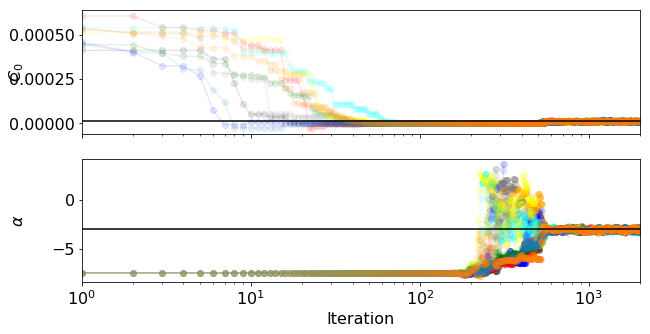

In [19]:
chain_plot(spec_params,                    # from fit
           samples,                        # from fit 
           labels=[r'$C_0$',r'$\alpha$'],  # labels to plot on y axis
           truths=pars_pl)                 # true values

<h3>Independent of where we start to sample, we always converge to the range (actually, we don't converge). You see that in the fest few 100 iterations, the samples are too far off the right values, which is why we throw them away. We also see that the true values (black lines) are met nicely.</h3>

<h3>The next step is looking at the joint ($P(C_0,\alpha)$) and marginalised ($P(C_0)$ and $P(\alpha)$) distributions in a 'corner plot':</h3>

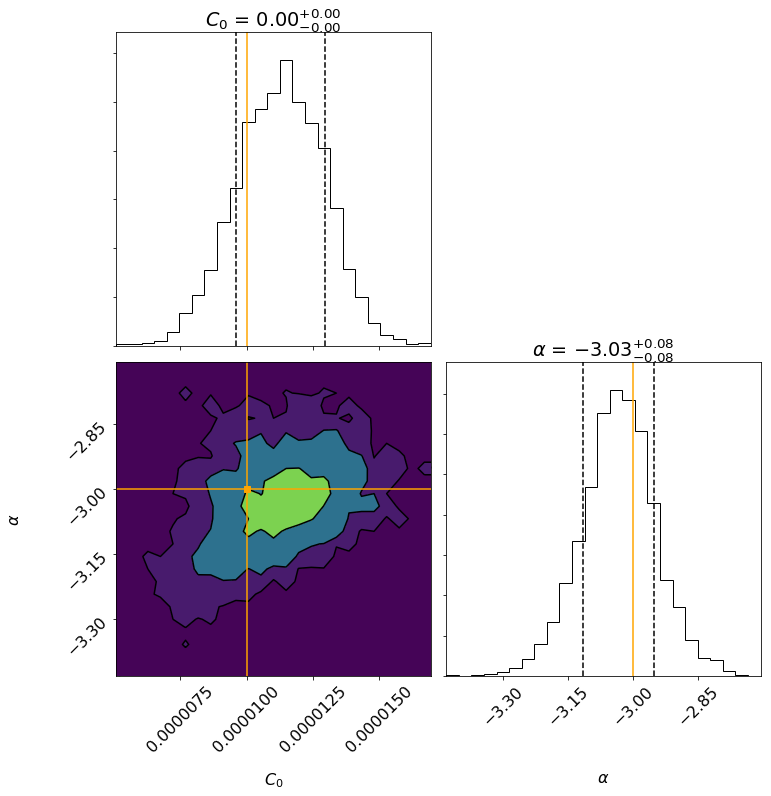

In [20]:
corner_plot(spec_params,                    # from fit
            samples,                        # from fit  
            labels=[r'$C_0$',r'$\alpha$'],  # labels for plotting
            truths=pars_pl)                 # true values

<h3>We see that the distributions are somewhat symmetric (maybe $C_0$ not because bound by $0$) and that the covariance bewteen the parameters (at least in this case) is somewhat small. Covariance means: how does one parameter change with respect to the change of another. Repeat the fit with a signal to noise ratio of 2 per bin and you will see what a strong anti-correlation looks like. Finally, we see that the true parameters (orange) fall in these distributions. It doesn't matter that they are not perfectly centred because the relisation of the data with their uncertainties also has a certain range.</h3>

<h3>And finally, we calculate the model spectra themselves, given these distributions. For each value on the x-axis, we calculate 2500 realisations of the model, as drawn from the samples:</h3>

In [21]:
# y_models is in the data space, y_modelsm is in model space
y_models, y_modelsm = calc_posterior(ee,          # data space energy bins
                                     dee,         # data space energy bin widths 
                                     matrix,      # rmf
                                     e_lo,        # rmf bins lo  
                                     e_hi,        # rmf bins hi
                                     e_mean,      # arbitrary array where the model is evaluated in photon space
                                     spec_params, # fitted parameters
                                     samples,     # samples
                                     'powerlaw')  # fit function

Loop over samples::   0%|          | 0/2500 [00:00<?, ?it/s]

Text(0.5, 0, 'Energy [keV]')

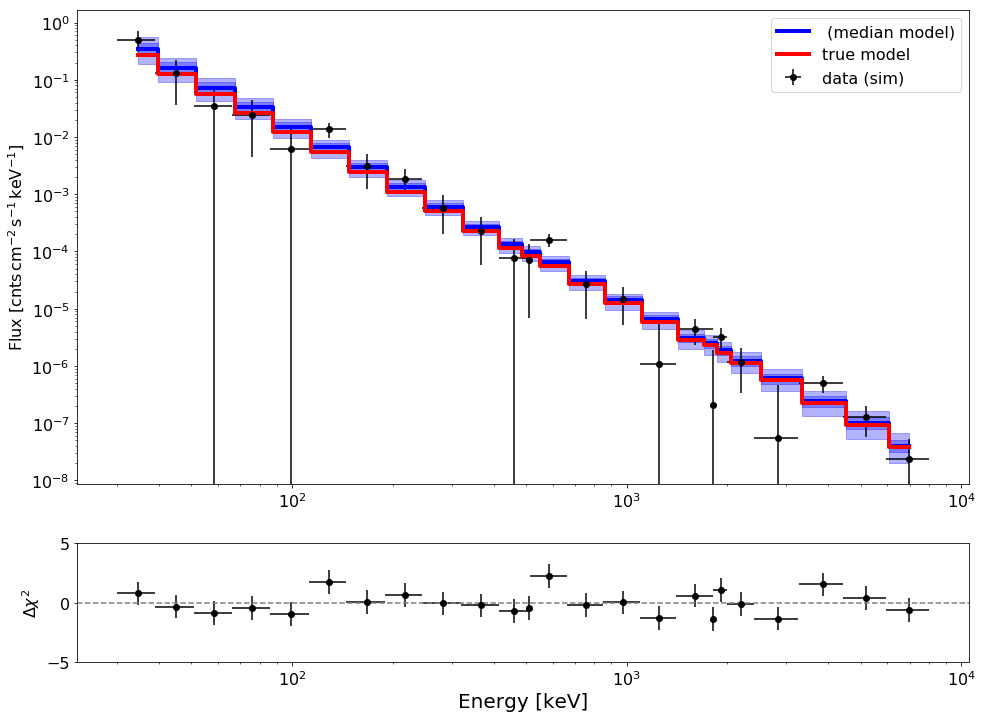

In [22]:
# plotting the fitted model and the uncertainty bands
fig, ax = plot_posterior(ee,y_models)

# define log axes
ax[0].set_xscale('log')
ax[0].set_yscale('log')

# overplotting the data that had been fitted
ax[0].errorbar(ee,
             fake_data,
             xerr=dee/2,
             yerr=fake_data_err,
             color='black',
             marker='o',
             linestyle='',
             label='data (sim)')

# overplotting the true model (should fall into blue bands)
ax[0].step(ee,
         fake_data_true,
         where='mid',
         color='red',
         label='true model',
         linewidth=4)

ax[0].set_ylabel(r'Flux [$\mathrm{cnts\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

# update legend
ax[0].legend()


# lower axis: fill with fit normalised residuals

# calculate median model
fit_model = np.median(y_models,axis=1)

# plot residuals
# calculate residuals
residuals = (fake_data-fit_model)/(fake_data_err)

# plot
ax[1].errorbar(ee,
              residuals,
              xerr=dee/2,
              yerr=fake_data_err/fake_data_err, # yes the normalised residuals all have uncertainty 1.0
              color='black',marker='o',linestyle='',
              label='residuals')

# log x axis
ax[1].set_xscale('log')

# zero line
ax[1].axhline(0,linestyle='--',color='gray')

# contribution to chi2 per bin
ax[1].set_ylabel(r'$\Delta \chi^2$')

# y axis range
ax[1].set_ylim(-5,5)

# x label
ax[1].set_xlabel('Energy [keV]',fontsize=20)

Text(0.5, 0, 'Energy [keV]')

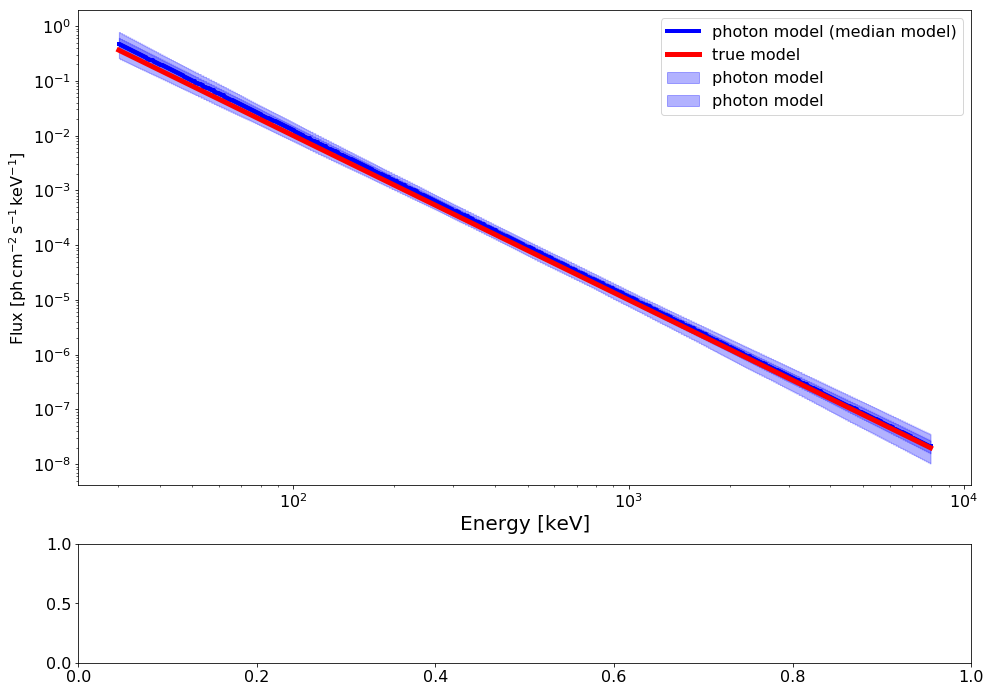

In [23]:
fig, ax = plot_posterior(e_mean,y_modelsm,label='photon model')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].plot(e_mean,
         powerlaw(e_mean,pars_pl),
         linewidth=5,
         color='red',
         label='true model')


ax[0].set_ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

ax[0].legend()

# x label
ax[0].set_xlabel('Energy [keV]',fontsize=20)

<h3>After these two plots it should be more clear what is meant by "model space" and what by "data space". We define our photon flux in model space, and transform it to the space our data live in.<br>
    We see that the true model is within the uncertainty bands, which tells us that our method works, and that the uncertainties on our parameters are reasonable. We can also calculate what $\chi(C_0^{best},\alpha^{best})$ is:</h3>

In [24]:
# as by definition of the likelihood as -0.5chi2, we get chi2 by multiplication by -2:
chi2_bestfit = -2*SPI_model_fit(spec_params[:,0],
                                ee,
                                fake_data,
                                dee,
                                fake_data_err,
                                matrix,
                                e_lo,
                                e_hi,
                                function='powerlaw',
                                eval=False) # note this changed.

In [25]:
# chi2
print('Chi2 = {0:1.2f}'.format(chi2_bestfit))

# reduced chi2
print('Reduced Chi2 = {0:1.2f}'.format(chi2_bestfit/(n_ee-2)))

Chi2 = 21.49
Reduced Chi2 = 0.98


<h3>Suppose now you want to estimate how much a certain additional component contributed to that spectrum.<br>
    This can be done in different ways, and some are more correct than others - whatever correct means.<br><br>
    First, I will show how your $\chi^2$-formalism would be done with the functions I provide here. Then, I will show how to include the 'astrophysical background', but not as fixed function, but with uncertainties included.<br><br>
    To start this, I assume a generic function that lives on some energy binning (like your tabulated model for the PBH evaporation). I define an energy binning, and an arbiratry function:</h3>

In [26]:
# energy binning of table model
e_new = np.logspace(1,4,1000)

# function of table model
mu = 6
sigma = 0.5
A0 = 1.
f_new = A0/(e_new*sigma*np.sqrt(2*np.pi))*np.exp(-0.5*(np.log(e_new)-mu)**2/sigma**2)

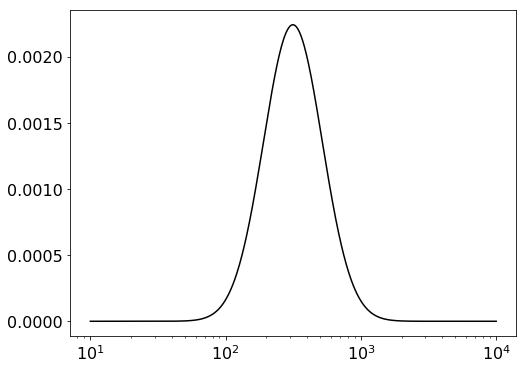

In [27]:
plt.plot(e_new,f_new)
plt.xscale('log')

<h3>I am mimicing the PBH evaopration with a log-normal function here. The important part is that i hard-coded its parameters $\mu$, $\sigma$, and $A_0$.<br>
    Now given this function on the energy binning $E_{new}$, we first have to interpolate it to the binning of our response matrix:</h3>

In [28]:
from scipy.interpolate import interp1d as interpol

In [29]:
f_func = interpol(e_new,f_new)
f_rmf = f_func(e_mean)

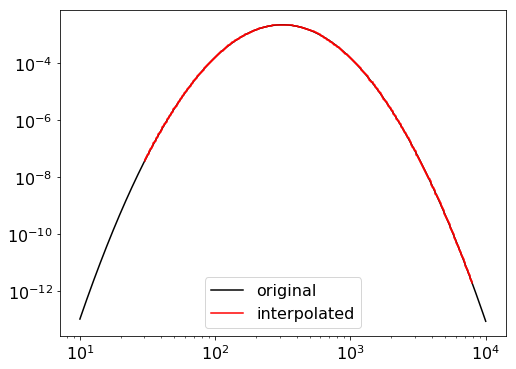

In [30]:
plt.plot(e_new,f_new,label='original')
plt.step(e_mean,f_rmf,where='mid',label='interpolated')
plt.legend()
plt.xscale('log')
plt.yscale('log')

<h3>The differences are marginal as expected from the initial fine binning. Note that the interpolated function is cut according to our data range.<br><br>
    Now we can calculate $\chi^2$ of this function with our simulated data, ignoring all other factors. Since our model is now fixed, and not parametrised in the spectral_shapes.py file, we have to do the integration ourselves:</h3>

In [31]:
# This is modified from the SPI_model_fit() function, as above:
# Integrate model with Simpson's rule over the rmf energy bins
integrated_model = (e_hi-e_lo)/6.0*(f_func(e_lo)+
                                    4*f_func((e_lo+e_hi)/2.0)+
                                    f_func(e_hi))

# Apply response matrix
folded_model = np.dot(integrated_model,matrix)

# Return to differential model
folded_differential_model = folded_model / dee

# Evaluate chi2
print(np.nansum((fake_data-folded_differential_model)**2/fake_data_err**2))

3003.702576171715


<h3>You can see how this can be turned into a loop over the amplitude $A_0$, so that one can find the 'minimum $\chi^2$' and some $\Delta \chi^2$ as an upper limit:</h3>

In [32]:
N_test = 100
A0_arr = np.logspace(-2,2,N_test)
chi2_arr = np.zeros(N_test)
for i in range(N_test):
    chi2_arr[i] = np.nansum((fake_data - A0_arr[i]*folded_differential_model)**2/fake_data_err**2)

Text(0, 0.5, '$\\Delta \\chi^2$')

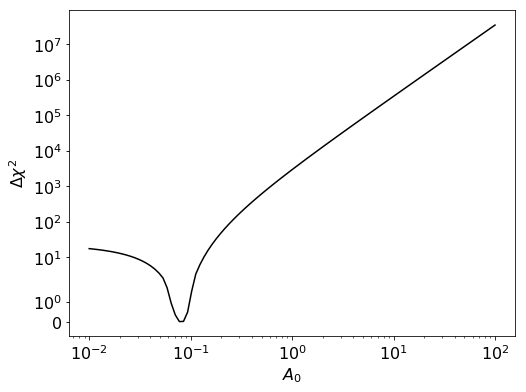

In [33]:
delta_chi2 = chi2_arr-np.min(chi2_arr)
plt.plot(A0_arr,delta_chi2)
plt.xscale('log')
plt.yscale('symlog')
plt.xlabel(r'$A_0$')
plt.ylabel('$\Delta \chi^2$')

<h3>We see a best-fit minimum for the amplitude $A_0$ ($\Delta \chi^2 = 0$) and we can find an upper bound, depending on what we want to calculate. Say we want to select the "$2\sigma$" upper bound, we search for $\Delta \chi^2 = 4$. Note that there are two solutions, but we want to know the positive one here:</h3>

In [34]:
A0_best = A0_arr[np.argmin(delta_chi2)]
A0_2sigma = A0_arr[(A0_arr > A0_best)][np.argmin(np.abs(delta_chi2[(A0_arr > A0_best)]-4))]

In [35]:
A0_best,A0_2sigma

(0.0774263682681127, 0.11233240329780277)

<h3>Let's plot this to convince us that this might be considered 'conservative' but not necessarily useful:</h3>

Text(0, 0.5, 'Flux [$\\mathrm{ph\\,cm^{-2}\\,s^{-1}\\,keV^{-1}}$]')

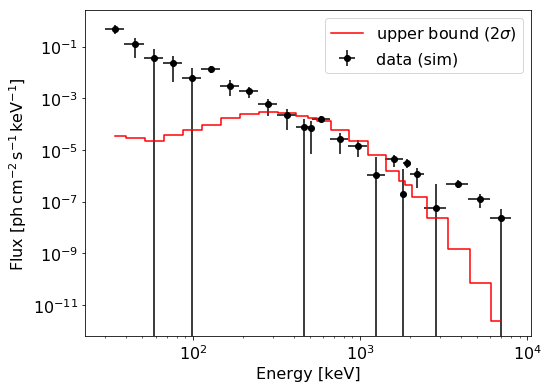

In [36]:
# plot simulated data
plt.errorbar(ee,
             fake_data,
             xerr=dee/2,
             yerr=fake_data_err,
             color='black',
             marker='o',
             linestyle='',
             label='data (sim)')

# plot true model (which has been sampled from)
plt.step(ee,
         A0_2sigma*folded_differential_model,
         where='mid',
         color='red',
         label=r'upper bound ($2\sigma$)')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

<h3>I intentionally say not useful, because the residuals of this 'fit' would be catastrophic. The model cannot explain the data, which means that inference with that model on that data is misleading.<br><br>
    If we know a reasonable description of that data, we should use it. Of course, most of the time in astrophysics, we don't know what is "correct" or "wrong". In fact, all models are wrong, but some of them are useful (quote by George Box). In our case, we know what the right model is, we just don't know it's parameters. This is the more general case in astrophysics, so we want to use a right (or useful) model to describe the data, and check if anything is not described by that model (e.g. PBH). Our data has uncertainties, and the (right) model also has uncertainties, which need to be propagated accordingly when the table model is included. That is not too tricky, but I have to switch to including the model as a file in the spectral_shapes.py collection of functions, so that I can use it together with the other models.<br>
    I make a .csv file to save the original spectrum to a file that I read in when i need to fit the model:</h3>

In [37]:
dat = {'Energy':e_new,
      'Flux':f_new}
df = pd.DataFrame(data=dat)

In [38]:
df.to_csv('test_spec.csv',index=False)

<h3>I intentionally saved the original file because I might want to use it for another rmf, etc.<br>
Make sure the file is placed into the spec_tools directory.</h3>

<h3>Finally, we need to combine the two functions in the spectral_shapes.py file and define a new one, so that we can fit them together. I call it fit_powerlaw_test_spec():</h3>

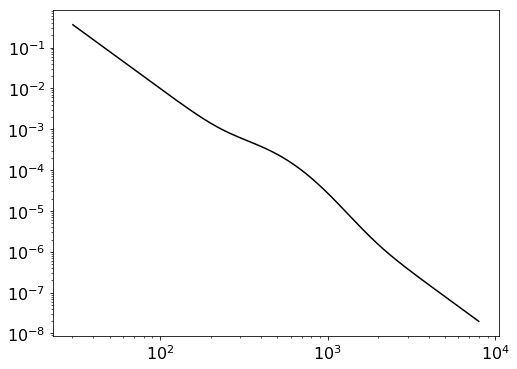

In [39]:
plt.loglog(e_mean,fit_powerlaw_test_spec(e_mean,[C0,alpha,A0_2sigma]))

In [40]:
# calculate new model total
new_model = SPI_model_fit([C0,alpha,A0_2sigma],
                               ee,
                               None,
                               dee,
                               None,
                               matrix,
                               e_lo,
                               e_hi,
                               function='fit_powerlaw_test_spec',
                               eval=True)

# powerlaw part
new_model_powerlaw = SPI_model_fit([C0,alpha],
                               ee,
                               None,
                               dee,
                               None,
                               matrix,
                               e_lo,
                               e_hi,
                               function='powerlaw',
                               eval=True)

# test_spec part
new_model_test_spec = SPI_model_fit([A0_2sigma],
                               ee,
                               None,
                               dee,
                               None,
                               matrix,
                               e_lo,
                               e_hi,
                               function='test_spec_func',
                               eval=True)

Text(0, 0.5, 'Flux [$\\mathrm{ph\\,cm^{-2}\\,s^{-1}\\,keV^{-1}}$]')

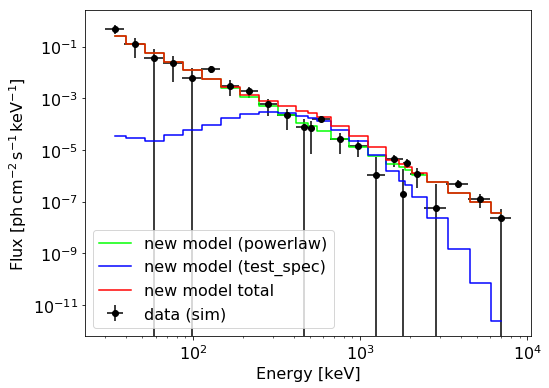

In [41]:
# plot simulated data
plt.errorbar(ee,
             fake_data,
             xerr=dee/2,
             yerr=fake_data_err,
             color='black',
             marker='o',
             linestyle='',
             label='data (sim)')


plt.step(ee,
         new_model_powerlaw,
         where='mid',
         color='lime',
         label='new model (powerlaw)')

plt.step(ee,
         new_model_test_spec,
         where='mid',
         color='blue',
         label='new model (test_spec)')

plt.step(ee,
         new_model,
         where='mid',
         color='red',
         label='new model total')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Energy [keV]')
plt.ylabel(r'Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

<h3>Now we can proceed as before and fit the new function. The only difference is that we then again have sampled points in our parameter space that we need to deal with:</h3>

In [42]:
# initial guess, the third entry is the amplitude of the new component
guess = [1e-5,-3.0,1]

# fitting the spectrum
spec_params_new, samples_new = fit_SPI_spec(ee,                # energy
                                    fake_data,         # flux
                                    dee,               # energy bin size
                                    fake_data_err,     # flux uncertainty
                                    matrix,            # rmf
                                    e_lo,              # rmf edges lo
                                    e_hi,              # rmf edges hi
                                    'fit_powerlaw_test_spec',        # fitting function
                                    guess,             # initial guess for fit  
                                    iters=2000)        # number of iterations (default = 2000)

100%|██████████| 2000/2000 [00:06<00:00, 310.53it/s]


Processing took 6.4 seconds


Results:

 Parameter      mean       std      0.15     15.85     50.00     84.15     99.85
        0:  1.07e-05  2.16e-06  3.84e-06  8.53e-06  1.08e-05  1.29e-05  1.71e-05
        1: -3.04e+00  9.75e-02 -3.42e+00 -3.13e+00 -3.04e+00 -2.95e+00 -2.68e+00
        2:  6.39e-03  2.21e-02 -5.53e-02 -1.60e-02  5.96e-03  2.86e-02  7.31e-02


<h3>Now, there is already the answer included that we are looking for: the upper bound on $A_0$ on some level: In the general results overview, the 99.85th percentile (~$3\sigma$) is $0.073$. Our 'conservative' $\Delta \chi^2$ estimate was $0.112$ (Note that these values might change depending on how the data are actually sampled, but the gist is always the same). If we include the 'astrophysical background' <em>and</em> its uncertainties, we derive a smaller bound.<br>Let's compare the same levels ($2\sigma$ vs $2\sigma$):</h3>

In [43]:
burnin = 1000
A0_ub = np.percentile(samples_new[burnin:,:,2],50+95.4/2)
A0_ub

0.05193931280483978

<h3>We obtain a $2\sigma$ upper bound on $A_0$ of $0.052$, have included all uncertainties, <em>and</em> the model descibes the data - suggesting that we do not need an additional component, as expected.<br>
    Let's plot our fit quality plots and the final spectrum with its component:</h3>

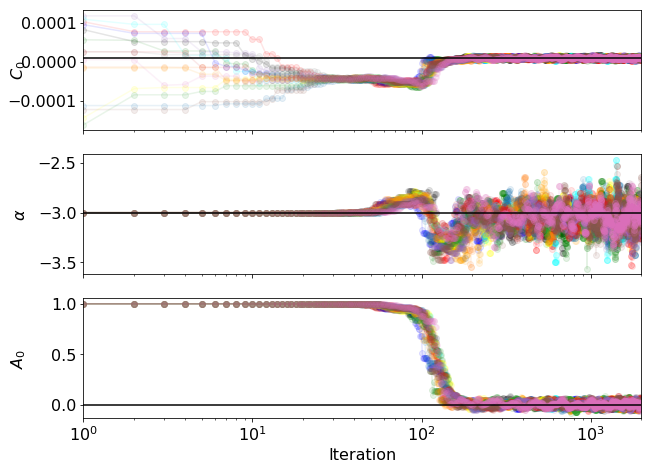

In [44]:
chain_plot(spec_params_new,                    # from fit
           samples_new,                        # from fit 
           labels=[r'$C_0$',r'$\alpha$',r'$A_0$'],  # labels to plot on y axis
           truths=[C0,alpha,0])                 # true values

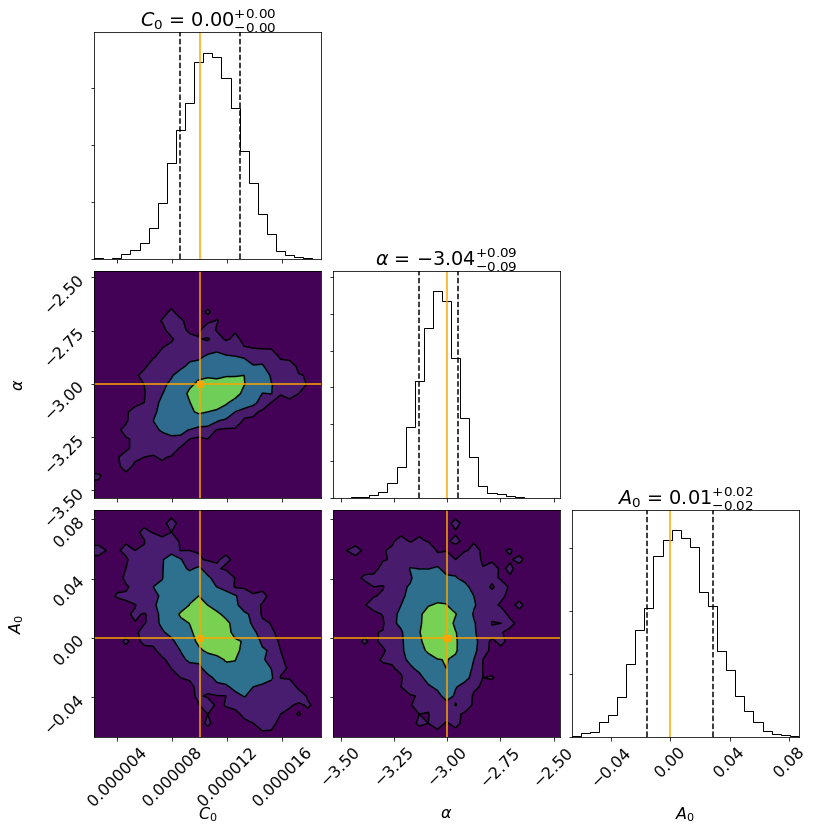

In [45]:
corner_plot(spec_params_new,                    # from fit
            samples_new,                        # from fit  
            labels=[r'$C_0$',r'$\alpha$',r'$A_0$'],  # labels for plotting
            truths=[C0,alpha,0])                 # true values

<h3>Note here that the amplitude $A_0$ of our additional component can also be negative. This is unphysical, and we should make sure that we don't do any unphysical stuff here. In the last example, I include priors to take this into account. But first, the plot:</h3>

In [46]:
# y_models is in the data space, y_modelsm is in model space
y_models_new, y_modelsm_new = calc_posterior(ee,          # data space energy bins
                                     dee,         # data space energy bin widths 
                                     matrix,      # rmf
                                     e_lo,        # rmf bins lo  
                                     e_hi,        # rmf bins hi
                                     e_mean,      # arbitrary array where the model is evaluated in photon space
                                     spec_params_new, # fitted parameters
                                     samples_new,     # samples
                                     'fit_powerlaw_test_spec')  # fit function

Loop over samples::   0%|          | 0/3750 [00:00<?, ?it/s]

Text(0.5, 0, 'Energy [keV]')

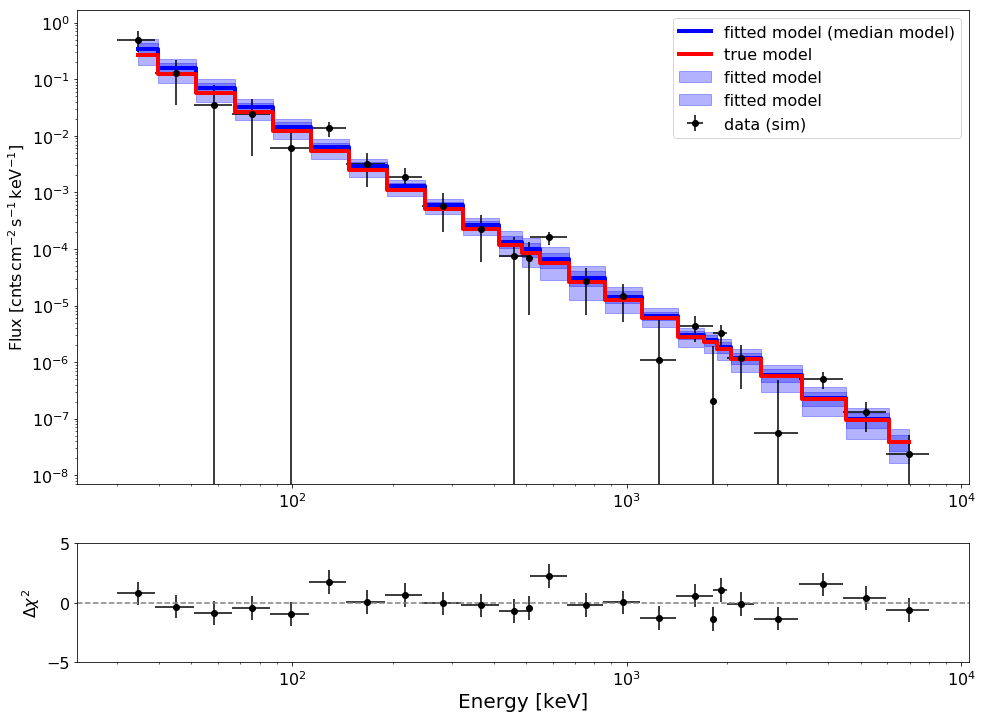

In [47]:
# plotting the fitted model and the uncertainty bands
fig, ax = plot_posterior(ee,y_models_new,label='fitted model')

# define log axes
ax[0].set_xscale('log')
ax[0].set_yscale('log')

# overplotting the data that had been fitted
ax[0].errorbar(ee,
             fake_data,
             xerr=dee/2,
             yerr=fake_data_err,
             color='black',
             marker='o',
             linestyle='',
             label='data (sim)')

# overplotting the true model (should fall into blue bands)
ax[0].step(ee,
         fake_data_true,
         where='mid',
         color='red',
         label='true model',
         linewidth=4)

ax[0].set_ylabel(r'Flux [$\mathrm{cnts\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

# update legend
ax[0].legend()


# lower axis: fill with fit normalised residuals

# calculate median model
fit_model = np.median(y_models,axis=1)

# plot residuals
# calculate residuals
residuals = (fake_data-fit_model)/(fake_data_err)

# plot
ax[1].errorbar(ee,
              residuals,
              xerr=dee/2,
              yerr=fake_data_err/fake_data_err, # yes the normalised residuals all have uncertainty 1.0
              color='black',marker='o',linestyle='',
              label='residuals')

# log x axis
ax[1].set_xscale('log')

# zero line
ax[1].axhline(0,linestyle='--',color='gray')

# contribution to chi2 per bin
ax[1].set_ylabel(r'$\Delta \chi^2$')

# y axis range
ax[1].set_ylim(-5,5)

# x label
ax[1].set_xlabel('Energy [keV]',fontsize=20)

In [48]:
# as by definition of the likelihood as -0.5chi2, we get chi2 by multiplication by -2:
chi2_bestfit_new = -2*SPI_model_fit(spec_params_new[:,0],
                                ee,
                                fake_data,
                                dee,
                                fake_data_err,
                                matrix,
                                e_lo,
                                e_hi,
                                function='fit_powerlaw_test_spec',
                                eval=False) # note this changed.

In [49]:
# chi2
print('Chi2 = {0:1.2f}'.format(chi2_bestfit_new))

# reduced chi2
print('Reduced Chi2 = {0:1.2f}'.format(chi2_bestfit_new/(n_ee-3)))

Chi2 = 21.46
Reduced Chi2 = 1.02


In [50]:
delta_chi2_fit = chi2_bestfit-chi2_bestfit_new
delta_chi2_fit

0.02881196760635163

<h3>We see that the $\Delta \chi^2$ between the old power-law-only model and the new model with our tabled spectrum is only or the order of a few. You can estimate the 'significance' of that additional component by a likelihood ratio test. In terms of $\chi^2$ with one additional component (delta degrees of freedom = 1), the significance is just $\sqrt{\Delta \chi^2}$. So, the significance is of the order of $1$-$3\sigma$, as expected from a non-existent additional component.</h3>

<h3>And finally, we want to include priors to the fit to avoid unphysical parameter ranges, for example, or to stabilise the fit when the data are sparse.<br><br>
    For each parameter, we have to think about a useful range to include so-called non-informative or weakly informative priors. These give a range of plausible values. For example, the index of a powerlaw will be equally probable to be between, say, -8 and 2, so we would give it a uniform prior probability distribution that $\alpha$ is only allowed to vary between these values. However, one might also consider positive indices as unphysical and reduce it to only negative ones, etc., or if we are sure that the power-law has something to do with particle acceleration, we expect an index around -2, and would give it a normal prior around -2. These are just examples. For the continuum normalisation we now that it must not be negative, but have otherwise hardly any information. Hardly any information can be included as log-uniform distribution, giving each decade of fluxes the same probability. And for our additional component, we are completely ignorant, and just know: it must be positive or zero.<br><br>
    We can include these priors as a dictionary, and repeat the fit as before:</h3>

In [51]:
prior_new2 = {0: ('log_uniform_prior',1e-10,1e-1,r'$C_0$'),
              1: ('uniform_prior',-8,2,r'$\alpha$'),
              2: ('truncated_normal_prior',0,10,0,np.inf,r'$A_0$')}

guess_new2 = [1e-3,alpha,0]

# fitting the spectrum
spec_params_new2, samples_new2 = fit_SPI_spec(ee,                # energy
                                    fake_data,         # flux
                                    dee,               # energy bin size
                                    fake_data_err,     # flux uncertainty
                                    matrix,            # rmf
                                    e_lo,              # rmf edges lo
                                    e_hi,              # rmf edges hi
                                    'fit_powerlaw_test_spec',        # fitting function
                                    guess_new2,         # initial guess for fit  
                                    iters=4000, # number of iterations (default = 20000)
                                    prior=prior_new2)    # prior    

  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 4000/4000 [00:13<00:00, 286.89it/s]

Processing took 13.9 seconds


Results:

 Parameter      mean       std      0.15     15.85     50.00     84.15     99.85
        0:  9.55e-06  2.11e-06  2.75e-06  7.43e-06  9.64e-06  1.17e-05  1.51e-05
        1: -3.06e+00  1.16e-01 -3.53e+00 -3.17e+00 -3.06e+00 -2.95e+00 -2.63e+00
        2:  2.29e-02  1.53e-02  4.74e-05  7.21e-03  2.07e-02  3.84e-02  8.25e-02


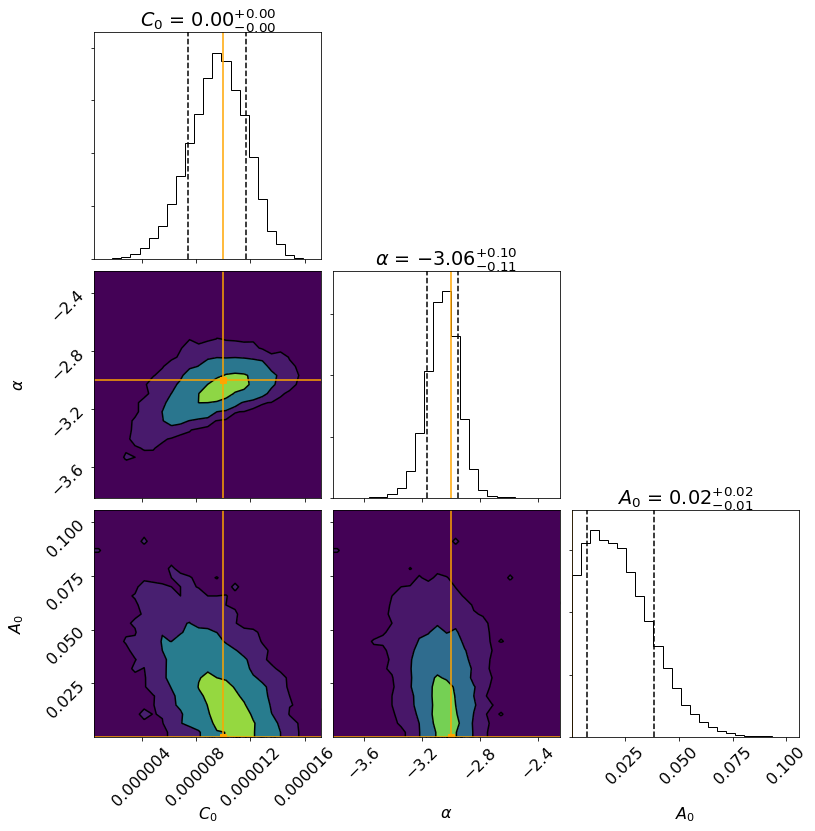

In [52]:
corner_plot(spec_params_new2,                    # from fit
            samples_new2,                        # from fit  
            labels=[r'$C_0$',r'$\alpha$',r'$A_0$'],  # labels for plotting
            truths=[C0,alpha,0])                 # true values

In [53]:
burnin = 2000
A0_ub2 = np.percentile(samples_new2[burnin:,:,2],50+95.4/2)

In [54]:
A0_ub,A0_ub2

(0.05193931280483978, 0.058801517325347025)

<h3>We see that taking into account physical bounds (like positivity of fluxes) again changes the upper bounds. In this case they become larger because all that probability that was on the negative side before, now is 'added' to the positive side, distorting the final posterior distribution.</h3>

<h3>Now you know how to deal with that data, fit models, add your our tabled models, and fit them including all the astrophysical background, its uncertainties, and the data uncertainties.<br><br>
    The next step would be using the data in the spectrum FITS file and repeat (and change toward useful things) what I have with this simulation.<br><br>
    I hope it becomes clear what the next steps will be for you. If not, let me know.</h3>

In [55]:
spec.info()

Filename: spec_tot_IC.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1  GROUPING      1 BinTableHDU     34   1R x 6C   [8A, 32A, 1J, 1J, 256A, 3A]   
  2  SPECTRUM      1 BinTableHDU    118   24R x 8C   [1I, 1E, 1E, 1E, 1I, 1I, 1E, 1E]   


In [58]:
flux_IC = spec['SPECTRUM'].data['DFLUX']
flux_IC_err = spec['SPECTRUM'].data['DFLUX_ERR']

In [59]:
prior_IC = {0: ('log_uniform_prior',1e-10,1e-1,r'$C_0^{IC}$'),
              1: ('uniform_prior',-8,2,r'$\alpha^{IC}$')}

guess_IC = [1e-3,-1.4]

# fitting the spectrum
spec_params_IC, samples_IC = fit_SPI_spec(ee,                # energy
                                          flux_IC,           # flux
                                          dee,               # energy bin size
                                          flux_IC_err,       # flux uncertainty
                                          matrix,            # rmf
                                          e_lo,              # rmf edges lo
                                          e_hi,              # rmf edges hi
                                          'powerlaw',        # fitting function
                                          guess_IC,          # initial guess for fit  
                                          iters=4000,        # number of iterations (default = 2000)
                                          prior=prior_IC)    # prior    

100%|██████████| 4000/4000 [00:05<00:00, 730.32it/s]

Processing took 5.5 seconds


Results:

 Parameter      mean       std      0.15     15.85     50.00     84.15     99.85
        0:  6.66e-06  3.58e-07  5.56e-06  6.30e-06  6.66e-06  7.03e-06  7.70e-06
        1: -1.36e+00  3.24e-02 -1.45e+00 -1.39e+00 -1.36e+00 -1.32e+00 -1.26e+00


In [106]:
# y_models is in the data space, y_modelsm is in model space
e_plot = np.logspace(1,5.3,250)

y_models_IC, y_modelsm_IC = calc_posterior(ee,          # data space energy bins
                                          dee,         # data space energy bin widths 
                                          matrix,      # rmf
                                          e_lo,        # rmf bins lo  
                                          e_hi,        # rmf bins hi
                                          e_plot,      # arbitrary array where the model is evaluated in photon space
                                          spec_params_IC, # fitted parameters
                                          samples_IC,     # samples
                                          'powerlaw')  # fit function

Loop over samples::   0%|          | 0/2500 [00:00<?, ?it/s]

<h3>Fermi/LAT data copied from Ackermann+2012:</h3>

In [116]:
fermi_lat_data = np.array([[236.28360263551727, 0.032110808716823494],
[374.91674433988817, 0.03727317941630176],
[594.8892077934331, 0.036242534351868035],
[933.0927435461664, 0.03683455114554743],
[1480.56018138991, 0.03426468409842223],
[2376.511113811073, 0.028325142075450734],
[3727.593720314938, 0.02174773577785949],
[5914.660544591746, 0.015975015769814506],
[9384.93086494272, 0.010124322694293742],
[14891.290324394087, 0.007773632329299384],
[23357.21469090121, 0.006238737549291176],
[37491.674433988854, 0.005311810751685443],
[58806.25988746757, 0.004589512911481026],
[94392.46843247663, 0.00357643993010089]])


In [117]:
fermi_ee = fermi_lat_data[:,0]*1e3
fermi_df_psr = fermi_lat_data[:,1]/fermi_lat_data[:,0]**2/1e3
fermi_sr_norm = (np.sin(np.deg2rad(8))-np.sin(np.deg2rad(-8)))*2*80*np.pi/180
fermi_df = fermi_df_psr*fermi_sr_norm

spi_sr_norm = (np.sin(np.deg2rad(47.5))-np.sin(np.deg2rad(-47.5)))*2*47.2*np.pi/180

In [118]:
fermi_sr_norm,spi_sr_norm

(0.7772892294283593, 2.4294627348244457)

Text(0.5, 0, 'Energy [keV]')

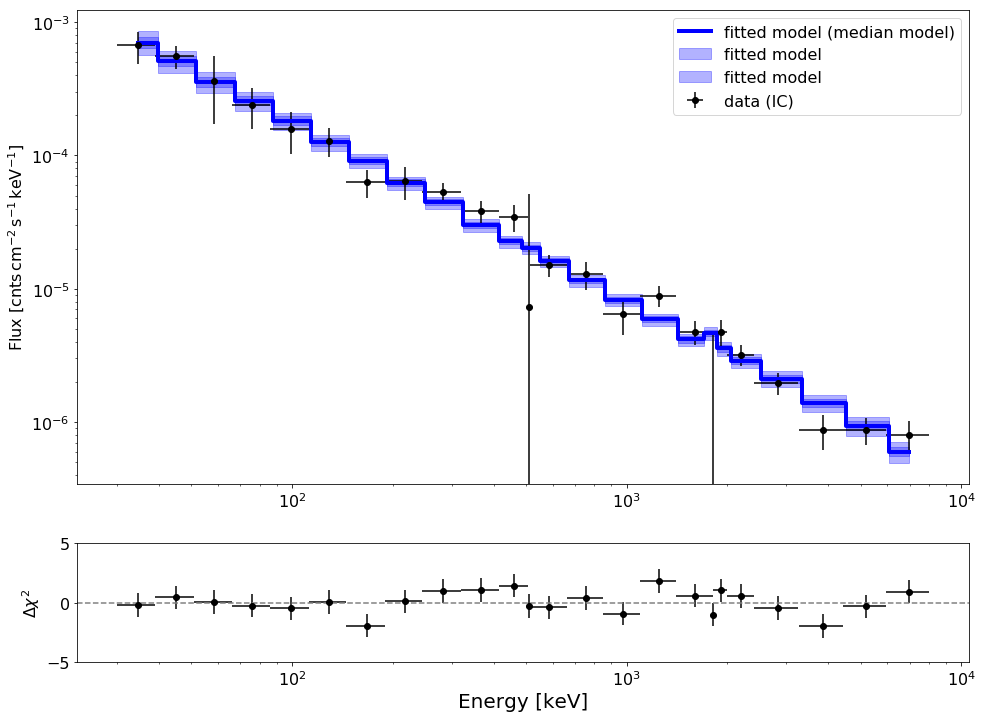

In [119]:
# plotting the fitted model and the uncertainty bands
fig, ax = plot_posterior(ee,y_models_IC,label='fitted model')

# define log axes
ax[0].set_xscale('log')
ax[0].set_yscale('log')

# overplotting the data that had been fitted
ax[0].errorbar(ee,
             flux_IC,
             xerr=dee/2,
             yerr=flux_IC_err,
             color='black',
             marker='o',
             linestyle='',
             label='data (IC)')

ax[0].set_ylabel(r'Flux [$\mathrm{cnts\,cm^{-2}\,s^{-1}\,keV^{-1}}$]')

# update legend
ax[0].legend()


# lower axis: fill with fit normalised residuals

# calculate median model
fit_model_IC = np.median(y_models_IC,axis=1)

# plot residuals
# calculate residuals
residuals = (flux_IC-fit_model_IC)/(flux_IC_err)

# plot
ax[1].errorbar(ee,
              residuals,
              xerr=dee/2,
              yerr=flux_IC_err/flux_IC_err, # yes the normalised residuals all have uncertainty 1.0
              color='black',marker='o',linestyle='',
              label='residuals')

# log x axis
ax[1].set_xscale('log')

# zero line
ax[1].axhline(0,linestyle='--',color='gray')

# contribution to chi2 per bin
ax[1].set_ylabel(r'$\Delta \chi^2$')

# y axis range
ax[1].set_ylim(-5,5)

# x label
ax[1].set_xlabel('Energy [keV]',fontsize=20)

Text(0.5, 0, 'Energy [keV]')

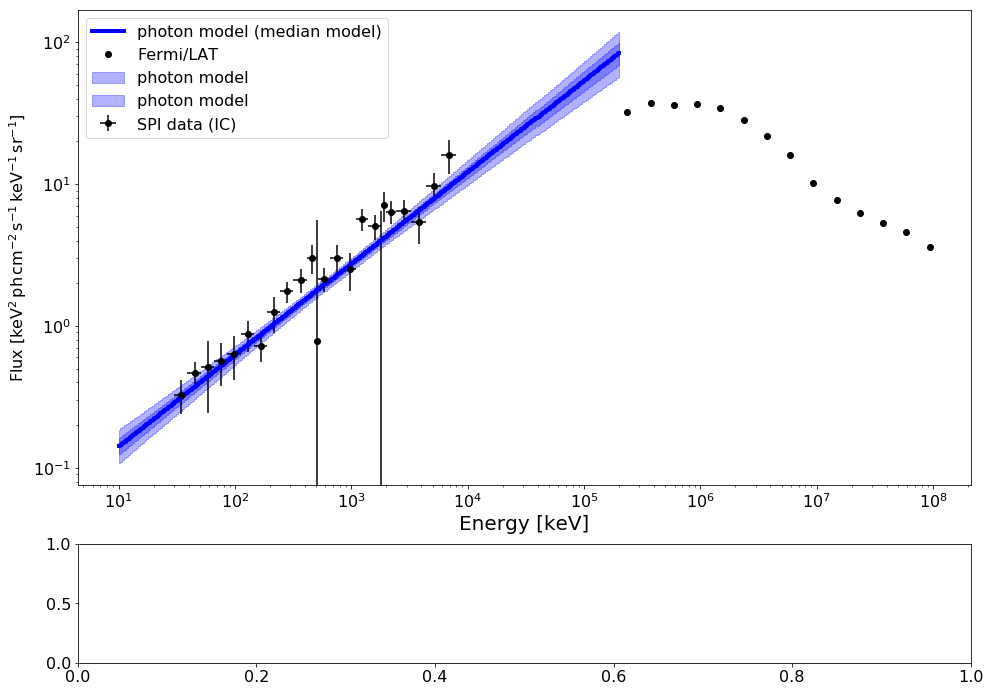

In [123]:
edx = 2

fig, ax = plot_posterior(e_plot,y_modelsm_IC/spi_sr_norm,label='photon model',edx=edx)

ax[0].errorbar(ee,
             flux_IC*ee**edx/spi_sr_norm,
             xerr=dee/2,
             yerr=flux_IC_err*ee**edx/spi_sr_norm,
             color='black',
             marker='o',
             linestyle='',
             label='SPI data (IC)')

ax[0].plot(fermi_ee,fermi_df_psr*fermi_ee**edx,'o',label='Fermi/LAT')

ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].set_ylabel(r'Flux [$\mathrm{keV^2\,ph\,cm^{-2}\,s^{-1}\,keV^{-1}\,sr^{-1}}$]')

ax[0].legend()

# x label
ax[0].set_xlabel('Energy [keV]',fontsize=20)

<h3>As a first test, not too bad. If we fit the IC component with a power-law, and extrapolate that to the Fermi/LAT range, we get a pretty good match within a factor of a few.<br>Note that the IC component should follow an IC spectrum and the power-law is just used as a means of descriptive function.)</h3>

<h3>etc</h3>